## This code runs for Case 3 End of Century - Chapter 6
## Parameterisation + Times series plotting + Demand Flow generation + Evaluation metrics + additional parallel plots and crop wise plots 
## last updated on 04-08-2024
contact asarfraz1@sheffield.ac.uk for any querries


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import qmc

def assure_path_exists(path):
    if not os.path.exists(path):
        print(f"Creating directory: {path}")
        os.makedirs(path)
    else:
        print(f"Directory already exists: {path}")

def month_range_str(start_month):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return f"{months[start_month]}-{months[(start_month+1)%12]}-{months[(start_month+2)%12]}"


def lhs_params(param_ranges, n_samples):
    n_params = len(param_ranges)
    sampler = qmc.LatinHypercube(d=n_params)
    lhs_samples = sampler.random(n=n_samples)
    for i in range(n_params):
        min_val, max_val = param_ranges[i]
        lhs_samples[:, i] = min_val + (max_val - min_val) * lhs_samples[:, i]
    return lhs_samples

def generate_demand_flows(lhs_samples):
    crops = ["Cotton", "Rice", "Wheat", "Sugarcane", "Miscellaneous"]
    crop_percentages = {
        'Cotton': [0.00, 0.00, 0.00, 0.00, 0.10, 0.15, 0.20, 0.20, 0.15, 0.15, 0.05, 0.00],
        'Rice': [0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.25, 0.20, 0.20, 0.10, 0.00, 0.00],
        'Wheat': [0.20, 0.25, 0.25, 0.15, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.15],
        'Sugarcane': [0.083] * 12,
        'Miscellaneous': [0.083] * 12
    }
    
    demand_flows = {}
    for i, crop in enumerate(crops):
        annual_demands = lhs_samples[:, i+2]  # +2 because the first two columns are supply parameters
        monthly_demands = np.outer(annual_demands, crop_percentages[crop])
        demand_flows[crop] = monthly_demands
        print(f"{crop} Demand Range: {np.min(annual_demands):.3f} - {np.max(annual_demands):.3f}")
    return demand_flows



def ComponentRescaling(sites, HistoricalMonthlyQ, LHsamples, rescaled_folder):
    mMonths = 12
    nScenarios = LHsamples.shape[0]
    nYears = len(HistoricalMonthlyQ) // mMonths

    historical_avg = np.mean(HistoricalMonthlyQ.reshape(nYears, mMonths), axis=0)
    
    for j in range(nScenarios):
        amplitude, lambda_coeff = LHsamples[j, :]
        
        NewMonthlyQ = np.zeros(len(HistoricalMonthlyQ))
        for m in range(12):
            k = (m + 3) % 12
            q_new = amplitude * (lambda_coeff * historical_avg[k] + (1 - lambda_coeff) * historical_avg[m])
            NewMonthlyQ[m::mMonths] = q_new
        
        for site in sites:
            file_path = os.path.join(rescaled_folder, f"{site}_Scenario{j+1}.csv")
            np.savetxt(file_path, NewMonthlyQ, fmt='%.3f', delimiter=',')
        
        scaling_factors = NewMonthlyQ[:mMonths] / historical_avg
        scaling_factors_path = os.path.join(rescaled_folder, f"Scenario{j+1}_scaling_factors.txt")
        np.savetxt(scaling_factors_path, scaling_factors, fmt='%.3f')

def CombineRescaledWithRainbase(sites, nScenarios, rescaled_folder, rainbase_data, combined_folder):
    nYears = 30
    mMonths = 12
    total_months = nYears * mMonths
    
    if len(rainbase_data) < total_months:
        rainbase_data = np.tile(rainbase_data, (total_months // len(rainbase_data) + 1))[:total_months]
    
    rainbase_reshaped = rainbase_data.reshape(nYears, mMonths)
    
    for i in range(nScenarios):
        for site in sites:
            rescaled_data = np.loadtxt(os.path.join(rescaled_folder, f"{site}_Scenario{i+1}.csv"), delimiter=',')
            
            if rescaled_data.shape != (nYears, mMonths):
                rescaled_data = rescaled_data.reshape(nYears, mMonths)
            
            combined_data = rescaled_data + rainbase_reshaped
            file_path = os.path.join(combined_folder, f"total_{site}_Scenario{i+1}.csv")
            np.savetxt(file_path, combined_data, fmt='%.3f', delimiter=',')

def CombineSupplyFlows(sites, nScenarios, combined_folder, supply_flows_rescaled_folder):
    nYears = 30
    mMonths = 12
    for i in range(1, nScenarios + 1):
        combined_sum = np.zeros((nYears, mMonths))
        
        for site in sites:
            file_path = os.path.join(combined_folder, f"total_{site}_Scenario{i}.csv")
            data = np.loadtxt(file_path, delimiter=',')
            combined_sum += data
        
        output_file_path = os.path.join(supply_flows_rescaled_folder, f"supply_Scenario{i}.csv")
        np.savetxt(output_file_path, combined_sum, fmt='%.3f', delimiter=',')
        print(f"Saved combined supply flow to {output_file_path}")

def calculate_average_flows(input_folder, output_folder, prefix):
    assure_path_exists(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            data = np.loadtxt(file_path, delimiter=',')
            
            average_data = np.mean(data, axis=0)
            
            output_file_path = os.path.join(output_folder, f"{prefix}_{filename}")
            np.savetxt(output_file_path, average_data.reshape(1, -1), fmt='%.3f', delimiter=',')


In [2]:
def calculate_var_metrics(supply_data, demand_flows, current_storage=14.3, potential_storage=18):
    n_scenarios = len(supply_data)
    
    annual_scarcity = np.zeros(n_scenarios)
    surplus_capacity = np.zeros(n_scenarios)
    deficit_severity = np.zeros(n_scenarios)
    variability = np.zeros(n_scenarios)
    best_months = np.zeros(n_scenarios, dtype=int)
    worst_months = np.zeros(n_scenarios, dtype=int)
    storage_adequacy = np.zeros(n_scenarios)
    storage_adequacy_points = np.zeros(n_scenarios, dtype=int)
    
    for i in range(n_scenarios):
        monthly_supply = np.mean(supply_data[i], axis=0)
        monthly_demand = np.sum([demand_flows[crop][i] for crop in demand_flows], axis=0)
        
        annual_supply = np.sum(monthly_supply)
        annual_demand = np.sum(monthly_demand)
        annual_scarcity[i] = annual_demand / annual_supply
        
        extended_supply = np.concatenate([monthly_supply[-2:], monthly_supply, monthly_supply[:2]])
        extended_demand = np.concatenate([monthly_demand[-2:], monthly_demand, monthly_demand[:2]])
        
        rolling_supply = np.convolve(extended_supply, np.ones(3), 'valid') /3
        rolling_demand = np.convolve(extended_demand, np.ones(3), 'valid') /3
        
        rolling_balance = rolling_supply - rolling_demand
        
        best_balance = np.max(rolling_balance)
        worst_balance = np.min(rolling_balance)
        variability[i] = best_balance - worst_balance
        
        best_months[i] = np.argmax(rolling_balance) % 12
        worst_months[i] = np.argmin(rolling_balance) % 12
        
        surplus_capacity[i] = best_balance
        deficit_severity[i] = -worst_balance
        
        storage_adequacy[i] = current_storage / variability[i]
        
        if variability[i] <= current_storage:
            storage_adequacy_points[i] = 1  # Adequate for both current and potential storage
        elif variability[i] <= (current_storage + potential_storage):
            storage_adequacy_points[i] = 2  # Adequate for future combined
        else:
            storage_adequacy_points[i] = 0  # Inadequate for both
    
    return annual_scarcity, variability, surplus_capacity, deficit_severity, best_months, worst_months, storage_adequacy, storage_adequacy_points

def plot_lambda_vs_amplitude_updated_again(data, metrics, output_file):
    descriptive_labels = {
        'Variability': 'Variability',
        'Deficit_Severity': 'Deficit Severity',
        'Surplus_Capacity': 'Surplus Capacity',
    }
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # Increased figure width
    fig.suptitle('Lambda vs Amplitude', fontsize=16)
    
    axs = axs.flatten()
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
    
    for i, metric in enumerate(metrics):
        ax = axs[i]
        
        if metric == 'Annual_Scarcity':
            scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], 
                                 c=data[metric], cmap='coolwarm')
            ax.set_title(f'Annual Scarcity')
            plt.colorbar(scatter, ax=ax, label='Annual Scarcity')
        
        elif metric in ['Variability','Deficit_Severity','Surplus_Capacity']:
            scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], 
                                 c=data[metric], cmap='coolwarm')
            ax.set_title(descriptive_labels[metric])
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label(descriptive_labels[metric],labelpad=15)
        
        elif metric == 'Storage_Adequacy_Points':
            colors = ['red' if val == 0 else 'yellow' if val == 1 else '#1f77b4' for val in data[metric]]
            scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], c=colors)
            ax.set_title('Storage Adequacy')
        
        ax.set_xlabel('Lambda')
        ax.set_ylabel('Amplitude')
        ax.text(0.03, 1.07, subplot_labels[i], transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white'))
    
    # Create legend for Storage Adequacy
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Inadequate for both (0)',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Adequate for both current and potential (1)',
               markerfacecolor='yellow', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Adequate for future combined (2)',
               markerfacecolor='#1f77b4', markersize=10)
    ]
    
    # Place legend in the empty space on the right
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.9, 0.3), title='Storage Adequacy')
    
    fig.delaxes(axs[5])
    
    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=600)
    plt.close()

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

def create_time_series_plots_with_crops(supply_flows_rescaled_FINAL, demand_flows, results_folder):
    supply_files = [f for f in os.listdir(supply_flows_rescaled_FINAL) if f.endswith('.csv')]
    n_months = 12

    supply_data = []
    for file in supply_files:
        supply = np.loadtxt(os.path.join(supply_flows_rescaled_FINAL, file), delimiter=',')
        supply_data.append(supply)

    # Calculate statistics for supply
    supply_max = np.max(supply_data, axis=0)
    supply_min = np.min(supply_data, axis=0)
    supply_avg = np.mean(supply_data, axis=0)

    # Prepare the figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=False)  # Changed sharey to False
    months = range(1, n_months + 1)

    # Plot for supply
    ax1.fill_between(months, supply_min, supply_max, alpha=0.2, color='gray', label='Supply Range')
    ax1.plot(months, supply_avg, label='Average Supply', color='gray', linewidth=2)
    ax1.set_title('Supply Time Series')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Water Volume')
    ax1.set_xticks(months)
    ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax1.legend()

    # Plot for demand with shaded regions
    crops = ['Cotton', 'Rice', 'Wheat', 'Sugarcane', 'Miscellaneous']
    colors = ['yellow', 'purple', 'blue', 'red', 'cyan']
    alpha_values = [0.2, 0.1, 0.1, 0.1, 0.2]  # Different transparency for each crop
    for crop, color, alpha in zip(crops, colors, alpha_values):
        crop_demand_data = np.array(demand_flows[crop])
        crop_demand_avg = np.mean(crop_demand_data, axis=0)
        crop_demand_max = np.max(crop_demand_data, axis=0)
        crop_demand_min = np.min(crop_demand_data, axis=0)
        ax2.plot(months, crop_demand_avg, label=f'{crop} Demand', color=color, linewidth=2)
        ax2.fill_between(months, crop_demand_min, crop_demand_max, color=color, alpha=alpha)

    # Calculate total demand statistics
    total_demand_data = np.sum([np.array(demand_flows[crop]) for crop in crops], axis=0)
    total_demand_avg = np.mean(total_demand_data, axis=0)
    total_demand_max = np.max(total_demand_data, axis=0)
    total_demand_min = np.min(total_demand_data, axis=0)

    # Plot total demand statistics
    ax2.plot(months, total_demand_avg, label='Average Demand', color='black', linewidth=2, linestyle='--')
    ax2.fill_between(months, total_demand_min, total_demand_max, color='black', alpha=0.1,label='Demand Range')
    ax2.set_title('Demand Time Series')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Water Volume')  # Added y-axis label for demand
    ax2.set_xticks(months)
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax2.legend()

    # Adjust the y-axis limits based on both supply and demand maximum values
    max_val = max(supply_max.max(), total_demand_max.max())
    ax1.set_ylim(0, max_val)
    ax2.set_ylim(0, max_val)

    plt.tight_layout()
    plt.savefig(os.path.join(results_folder, 'supply_demand_comparison.png'), bbox_inches='tight', dpi=600)
    plt.close()

    print(f"Time series comparison plot has been saved in {results_folder}")
    print("\nSummary Statistics:")
    print(f"Supply - Min: {supply_min.min():.4f}, Max: {supply_max.max():.4f}, Avg: {supply_avg.mean():.4f}")
    print(f"Total Demand - Min: {total_demand_min.min():.4f}, Max: {total_demand_max.max():.4f}, Avg: {total_demand_avg.mean():.4f}")
    for crop in crops:
        crop_demand_data = np.array(demand_flows[crop])
        crop_demand_avg = np.mean(crop_demand_data, axis=0)
        crop_demand_min = np.min(crop_demand_data, axis=0)
        crop_demand_max = np.max(crop_demand_data, axis=0)
        print(f"{crop} Demand - Min: {crop_demand_min.min():.4f}, Max: {crop_demand_max.max():.4f}, Avg: {crop_demand_avg.mean():.4f}")

# The rest of your code for defining demand_flows, setting paths, and calling the function remains unchanged.


In [4]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio


def create_parallel_coordinates_plot_up(data, output_file):
    # Prepare the data
    plot_data = data[['Cotton_Demand', 'Rice_Demand', 'Wheat_Demand', 'Sugarcane_Demand', 'Miscellaneous_Demand',
                      'Annual_Scarcity', 'Variability','Storage_Adequacy_Points']]

    # Define dimension names and ranges
    dimensions = [
        dict(label='Cotton Demand', values=plot_data['Cotton_Demand']),
        dict(label='Rice Demand', values=plot_data['Rice_Demand']),
        dict(label='Wheat Demand', values=plot_data['Wheat_Demand']),
        dict(label='Sugarcane Demand', values=plot_data['Sugarcane_Demand']),
        dict(label='Misc. Demand', values=plot_data['Miscellaneous_Demand']),
        dict(label='Annual Scarcity', values=plot_data['Annual_Scarcity']),
        dict(label='Variability', values=plot_data['Variability']),
        dict(label='Storage Adequacy', values=plot_data['Storage_Adequacy_Points'])
    ]

    # Create color scale
    color_scale = [[0, 'red'], [0.5, 'yellow'], [1, '#1f77b4']]

    # Create the parallel coordinates plot
    fig = go.Figure(data=
        go.Parcoords(
            line = dict(color = plot_data['Storage_Adequacy_Points'],
                        colorscale = color_scale),
            dimensions = dimensions
        )
    )

    # Update the layout
    fig.update_layout(
        title='Parallel Coordinates Plot of Supply, Demand, and Metrics',
        plot_bgcolor = 'white',
        paper_bgcolor = 'white'
    )

    # Save the plot as an interactive HTML file
    pio.write_html(fig, file=output_file, auto_open=False)

    print(f"Parallel coordinates plot saved as {output_file}")

In [5]:
def main():
    sites = ['All']  
    nMonths = 12
    n_samples = 1000

    # All parameter ranges (2 supply + 5 demand)
    all_param_ranges = [
        [0.47, 1.78],      # Supply Amplitude
        [0, 1],            # Supply lambda
        [6.2844, 106.5503],   # Cotton demand
        [0.00, 86.1922],  # Rice demand
        [0.7141, 97.3107],    # Wheat demand
        [1.2042, 162.1384],   # Sugarcane demand
        [3.3697, 47.7030],    # Miscellaneous demand
    ]

    # Generate LHS samples for all parameters
    all_lhs_samples = lhs_params(all_param_ranges, n_samples)

    np.savetxt("LHsamples_all_params.txt", all_lhs_samples, fmt='%.6f')

    supply_lhs_samples = all_lhs_samples[:, :2]
    demand_flows = generate_demand_flows(all_lhs_samples)


    Qgs = np.loadtxt('meltwater_hist_km3.txt')
    Qall = np.loadtxt('total_km3.txt')
    rainbase_data = np.loadtxt('rainbase_km3.txt')

    supply_flows_folder = './Case3_km3'
    rescaled_folder = os.path.join(supply_flows_folder, '1. rescaled_meltwater')
    combined_folder = os.path.join(supply_flows_folder, '2. combined')
    supply_flows_rescaled_folder = os.path.join(supply_flows_folder, '3. supply_flows_rescaled_combined')
    supply_flows_rescaled_FINAL = os.path.join(supply_flows_folder, '4. supply_flows_rescaled_FINAL')
    supply_demand_plot_folder = os.path.join(supply_flows_folder, '5. case3_supply_demand_plots')
    results_folder = os.path.join(supply_flows_folder, '6. results')
    
    for folder in [supply_flows_folder, rescaled_folder, combined_folder, supply_flows_rescaled_folder, 
                   supply_flows_rescaled_FINAL, supply_demand_plot_folder, results_folder]:
        assure_path_exists(folder)

    ComponentRescaling(sites, Qgs, supply_lhs_samples, rescaled_folder)
    CombineRescaledWithRainbase(sites, n_samples, rescaled_folder, rainbase_data, combined_folder)
    CombineSupplyFlows(sites, n_samples, combined_folder, supply_flows_rescaled_folder)
    calculate_average_flows(supply_flows_rescaled_folder, supply_flows_rescaled_FINAL, "FINAL_combined_rescaled")

    supply_data = []
    for i in range(n_samples):
        try:
            supply = np.loadtxt(os.path.join(supply_flows_rescaled_folder, f"supply_Scenario{i+1}.csv"), delimiter=',')
            supply_data.append(supply)
        except FileNotFoundError:
            print(f"Warning: supply_Scenario{i+1}.csv not found. Skipping this scenario.")
    
    print(f"Number of supply scenarios loaded: {len(supply_data)}")

    current_storage = 14.3  # km³
    potential_storage = 18.0  # km³
    
    create_time_series_plots_with_crops(supply_flows_rescaled_FINAL, demand_flows, results_folder)
    annual_scarcity, variability, surplus_capacity, deficit_severity, best_months, worst_months, storage_adequacy, storage_adequacy_points = calculate_var_metrics(supply_data, demand_flows, current_storage, potential_storage)
    
    print(f"Storage Adequacy - Min: {storage_adequacy.min():.4f}, Max: {storage_adequacy.max():.4f}, Mean: {storage_adequacy.mean():.4f}")
    print(f"Storage Adequacy Points - Counts: {np.bincount(storage_adequacy_points)}")

    scenario_data = pd.DataFrame({
        'Scenario': range(1, n_samples + 1),
        'Input_Amplitude': all_lhs_samples[:, 0],
        'Input_lambda': all_lhs_samples[:, 1],
        'Cotton_Demand': all_lhs_samples[:, 2],
        'Rice_Demand': all_lhs_samples[:, 3],
        'Wheat_Demand': all_lhs_samples[:, 4],
        'Sugarcane_Demand': all_lhs_samples[:, 5],
        'Miscellaneous_Demand': all_lhs_samples[:, 6],
        'Annual_Scarcity': annual_scarcity,
        'Variability': variability,
        'Surplus_Capacity': surplus_capacity,
        'Deficit_Severity': deficit_severity,
        'Storage_Adequacy': storage_adequacy,
        'Storage_Adequacy_Points': storage_adequacy_points,
        'Best_Months': [month_range_str(m) for m in best_months],
        'Worst_Months': [month_range_str(m) for m in worst_months]
    })

    # Save results
    scenario_data.to_csv(os.path.join(results_folder, 'complete_results.csv'), index=False)

    # Create summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean Annual Scarcity', 'Mean Variability', 'Mean Surplus Capacity', 'Mean Deficit Severity', 'Mean Storage Adequacy', 'Storage Adequacy Points Distribution'],
        'Value': [
            np.mean(annual_scarcity),
            np.mean(variability),
            np.mean(surplus_capacity),
            np.mean(deficit_severity),
            np.mean(storage_adequacy),
            str(np.bincount(storage_adequacy_points))
        ]
    })
    summary_stats.to_csv(os.path.join(results_folder, 'summary_statistics.csv'), index=False)

    # Plot results
    metrics = ['Annual_Scarcity', 'Deficit_Severity', 'Surplus_Capacity', 'Variability', 'Storage_Adequacy_Points']
    plot_lambda_vs_amplitude_updated_again(scenario_data, metrics, os.path.join(results_folder, 'Case3_results_5_panels.png'))
    create_parallel_coordinates_plot_up(scenario_data, os.path.join(results_folder, 'parallel_coordinates_plot_up.html'))

    print("Process completed successfully!")

if __name__ == "__main__":
    main()

Cotton Demand Range: 6.350 - 106.499
Rice Demand Range: 0.070 - 86.183
Wheat Demand Range: 0.781 - 97.217
Sugarcane Demand Range: 1.317 - 162.049
Miscellaneous Demand Range: 3.376 - 47.663
Creating directory: ./Case3_km3
Creating directory: ./Case3_km3\1. rescaled_meltwater
Creating directory: ./Case3_km3\2. combined
Creating directory: ./Case3_km3\3. supply_flows_rescaled_combined
Creating directory: ./Case3_km3\4. supply_flows_rescaled_FINAL
Creating directory: ./Case3_km3\5. case3_supply_demand_plots
Creating directory: ./Case3_km3\6. results
Saved combined supply flow to ./Case3_km3\3. supply_flows_rescaled_combined\supply_Scenario1.csv
Saved combined supply flow to ./Case3_km3\3. supply_flows_rescaled_combined\supply_Scenario2.csv
Saved combined supply flow to ./Case3_km3\3. supply_flows_rescaled_combined\supply_Scenario3.csv
Saved combined supply flow to ./Case3_km3\3. supply_flows_rescaled_combined\supply_Scenario4.csv
Saved combined supply flow to ./Case3_km3\3. supply_flows_re

## finalised plots for thesis

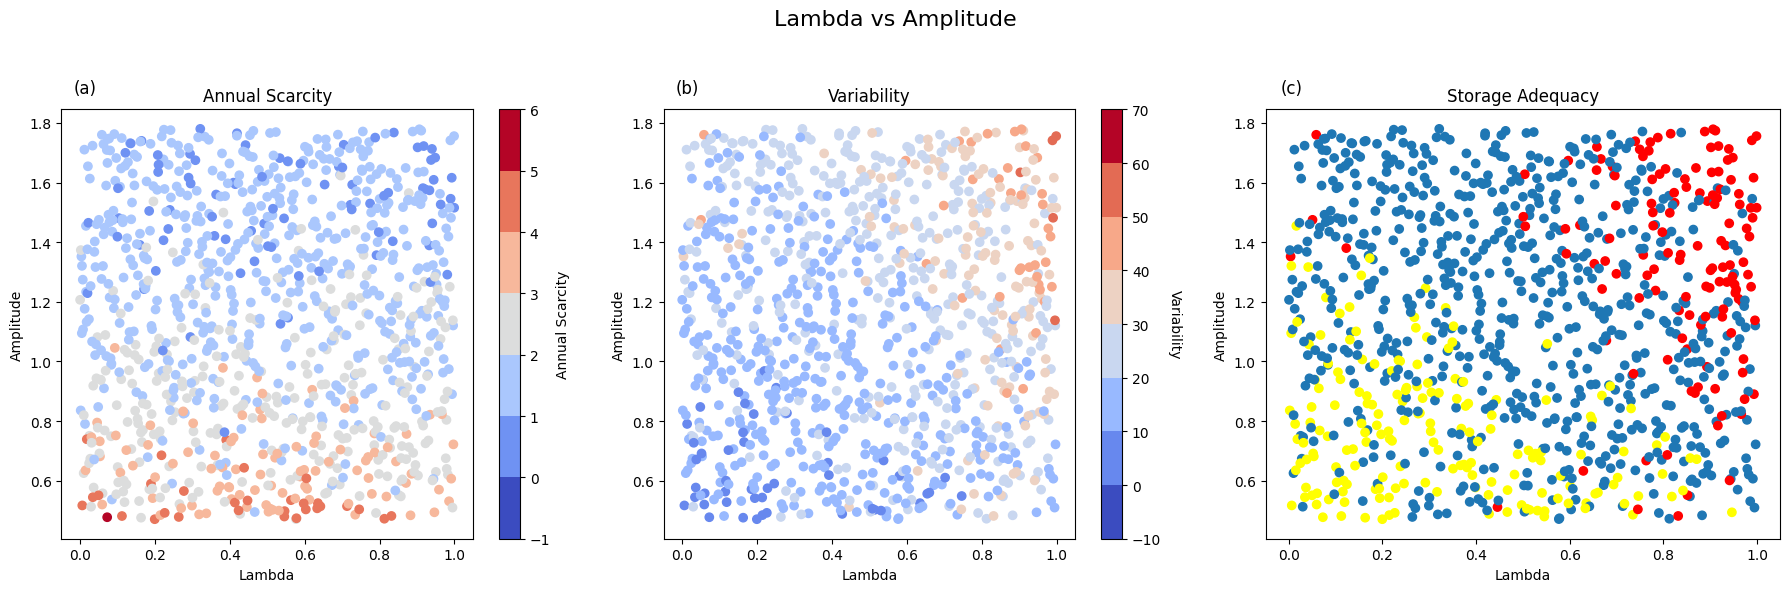

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm, BoundaryNorm

def plot_lambda_vs_amplitude_updated_thesis(data, metrics, output_file):
    descriptive_labels = {
        'Variability': 'Variability'
    }
    boundaries_linear = np.arange(-1, 7)  # -1 to 6
    cmap = plt.get_cmap('coolwarm')
    norm_linear = BoundaryNorm(boundaries_linear, ncolors=cmap.N, clip=True)

    boundaries_linear2 = np.arange(-10, 71, 10)  # Include 70 and go up to 71 to ensure 70 is included
    cmap2 = plt.get_cmap('coolwarm')
    norm_linear2 = BoundaryNorm(boundaries_linear2, ncolors=cmap2.N, clip=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Lambda vs Amplitude', fontsize=16)
    
    axs = axs.flatten()  # Ensuring all axes are in a 1D array
    subplot_labels = ['(a)', '(b)', '(c)']  # Labels for the subplots
    
    for i, metric in enumerate(metrics):
        ax = axs[i]
        # Scatter plots for each metric
        if metric == 'Annual_Scarcity':
            scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], 
                                 c=data[metric], cmap='coolwarm', norm=norm_linear)
            ax.set_title('Annual Scarcity')
            plt.colorbar(scatter, ax=ax, label='Annual Scarcity')
        
        elif metric in ['Variability']:
            scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], 
                                 c=data[metric], cmap='coolwarm',norm=norm_linear2)
            ax.set_title(descriptive_labels[metric])
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label(descriptive_labels[metric], rotation=270, labelpad=15)
        
        elif metric == 'Storage_Adequacy_Points':
            colors = ['red' if val == 0 else 'yellow' if val == 1 else '#1f77b4' for val in data[metric]]
            scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], c=colors)
            ax.set_title('Storage Adequacy')
            # Custom legend
            # from matplotlib.lines import Line2D
            
            # legend_elements = [Line2D([0], [0], marker='o', color='w', label='Inadequate (0)',
            #                           markerfacecolor='red', markersize=10),
            #                    Line2D([0], [0], marker='o', color='w', label='Adequate for both current and potential  (1)',
            #                           markerfacecolor='yellow', markersize=10),
            #                    Line2D([0], [0], marker='o', color='w', label='Adequate for future combined (2)',
            #                           markerfacecolor='#1f77b4', markersize=10)]
            # ax.legend(handles=legend_elements, loc='best')
        
        ax.set_xlabel('Lambda')
        ax.set_ylabel('Amplitude')
        # Setting subplot labels as requested
        ax.text(0.03, 1.07, subplot_labels[i], transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white'))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to not overlap with title
    # Uncomment the next line to save the figure
    plt.savefig(output_file, bbox_inches='tight', dpi=600)
    plt.show()

# Load your data
results_folder = './Case3_km3/6. results'
csv_file = os.path.join(results_folder, 'complete_results.csv')
data = pd.read_csv(csv_file)
metrics = ['Annual_Scarcity', 'Variability', 'Storage_Adequacy_Points']
output_file = os.path.join(results_folder,'case_3_final_scarcity_storage_adequacy.png')

plot_lambda_vs_amplitude_updated_thesis(data, metrics, output_file)


## aditional plots now 
## scarcity and storage adequacy 
**1. "Cotton + Rice" vs "Wheat"** 

**2. "Cotton + Rice" vs "Sugar + Misc"**

**3. "Sugar + Misc" vs " Wheat"**


Plot saved as ./Case3_km3/6. results\six_panel_crop_demand_storage_plot.png


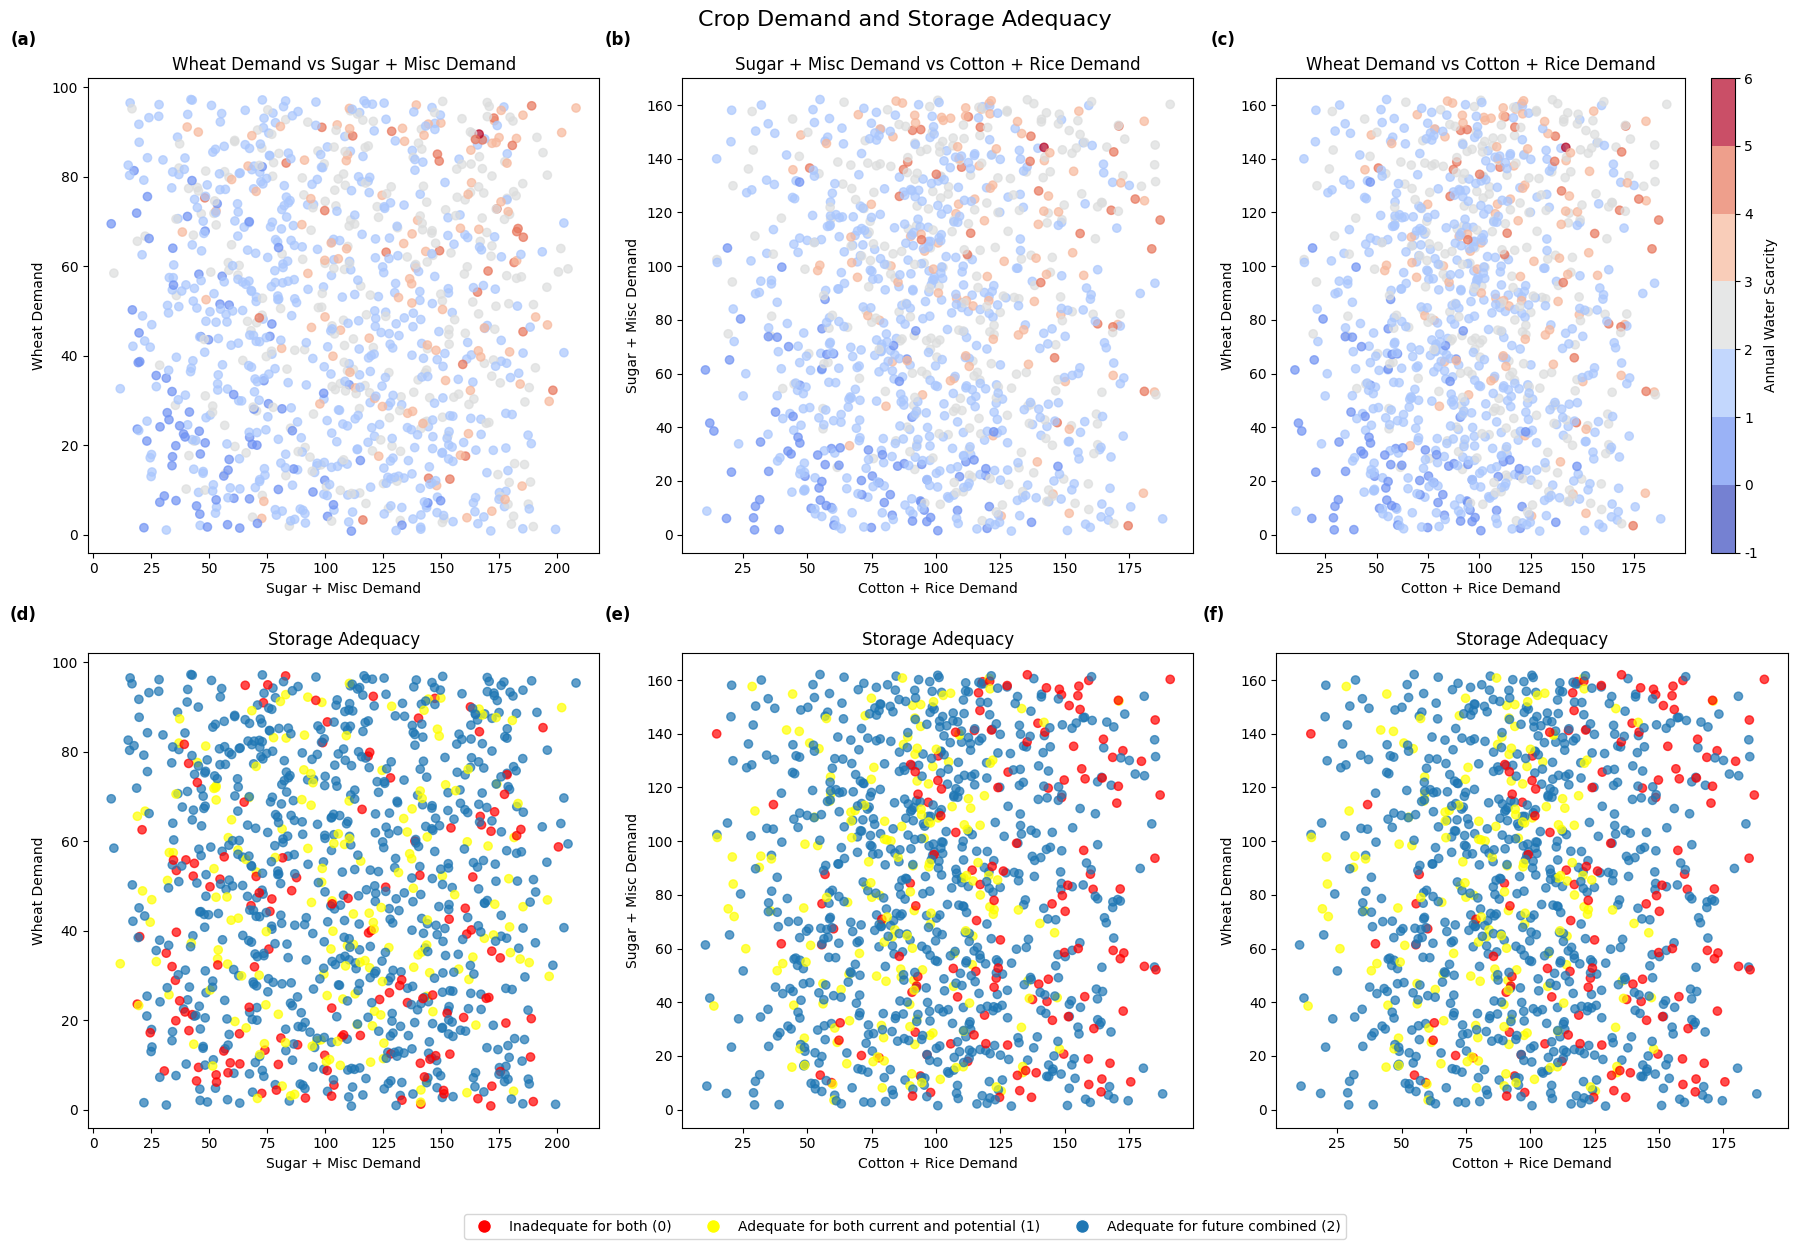

Six-panel plot has been generated and saved.


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def create_six_panel_plot(df, results_folder):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Crop Demand and Storage Adequacy', fontsize=16)

    plot_data = [
        ('Sugarcane_Demand', 'Miscellaneous_Demand', 'Wheat_Demand', 'Sugar + Misc Demand', 'Wheat Demand'),
        ('Cotton_Demand', 'Rice_Demand', 'Sugarcane_Demand', 'Cotton + Rice Demand', 'Sugar + Misc Demand'),
        ('Cotton_Demand', 'Rice_Demand', 'Sugarcane_Demand', 'Cotton + Rice Demand', 'Wheat Demand')
    ]

    for col, (x1, x2, y, x_label, y_label) in enumerate(plot_data):
        x_data = df[x1] + df[x2]
        y_data = df[y]

        # Crop demand plot
        ax = axs[0, col]
        boundaries_linear = np.arange(-1, 7)
        cmap = plt.get_cmap('coolwarm')
        norm_linear = BoundaryNorm(boundaries_linear, ncolors=cmap.N, clip=True)
        
        scatter = ax.scatter(x_data, y_data, 
                             c=df['Annual_Scarcity'], 
                             cmap=cmap,
                             norm=norm_linear,
                             alpha=0.7)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{y_label} vs {x_label}')
        
        if col == 2:  # Only add colorbar to the last plot in the first row
            cbar = fig.colorbar(scatter, ax=ax, ticks=np.arange(-1, 7))
            cbar.set_label('Annual Water Scarcity')
            cbar.ax.set_yticklabels(np.arange(-1, 7))

        # Storage adequacy plot
        ax = axs[1, col]
        colors = ['red', 'yellow', '#1f77b4']
        cmap = ListedColormap(colors)
        scatter = ax.scatter(x_data, y_data, 
                             c=df['Storage_Adequacy_Points'], 
                             cmap=cmap, 
                             vmin=-0.5, vmax=2.5,
                             alpha=0.7)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title('Storage Adequacy')

        # Add subplot labels
        axs[0, col].text(-0.1, 1.1, f'({chr(97+col)})', transform=axs[0, col].transAxes, 
                         fontsize=12, fontweight='bold', va='top', ha='right')
        axs[1, col].text(-0.1, 1.1, f'({chr(100+col)})', transform=axs[1, col].transAxes, 
                         fontsize=12, fontweight='bold', va='top', ha='right')

    # Add legend for storage adequacy
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Inadequate for both (0)',
                   markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Adequate for both current and potential (1)',
                   markerfacecolor='yellow', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Adequate for future combined (2)',
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    output_file = os.path.join(results_folder, 'six_panel_crop_demand_storage_plot.png')
    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    print(f"Plot saved as {output_file}")
    plt.show()

results_folder = './Case3_km3/6. results'
csv_file = os.path.join(results_folder, 'complete_results.csv')
df = pd.read_csv(csv_file)
create_six_panel_plot(df, results_folder)
print("Six-panel plot has been generated and saved.")

## Add parallel plot

In [9]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import os

def create_PP_log_grouped(data, output_file_png):
    # Calculate log of annual scarcity
    data['Log_Annual_Scarcity'] = np.log10(data['Annual_Scarcity'])

    # Sum up the demands
    data['Cotton_Rice_Demand'] = data['Cotton_Demand'] + data['Rice_Demand']
    data['Sugar_Misc_Demand'] = data['Sugarcane_Demand'] + data['Miscellaneous_Demand']

    # Prepare the plot data
    plot_data = data[['Cotton_Rice_Demand', 'Wheat_Demand', 'Sugar_Misc_Demand', 'Log_Annual_Scarcity', 'Variability', 'Storage_Adequacy_Points']]

    # Define dimensions for the parallel coordinates plot
    dimensions = [
        dict(label='Cotton + Rice', values=plot_data['Cotton_Rice_Demand']),
        dict(label='Wheat', values=plot_data['Wheat_Demand']),
        dict(label='Sugar+Misc.', values=plot_data['Sugar_Misc_Demand']),
        dict(label='Log Annual Scarcity', values=plot_data['Log_Annual_Scarcity']),
        dict(label='Variability', values=plot_data['Variability']),
        dict(label='Storage Adequacy', values=plot_data['Storage_Adequacy_Points'])
    ]

    # Restore your original color scale
    color_scale = [[0, 'red'], [0.5, 'yellow'], [1, '#1f77b4']] 

    # Create the parallel coordinates plot
    fig = go.Figure(data=go.Parcoords(line=dict(color=plot_data['Storage_Adequacy_Points'], colorscale=color_scale), dimensions=dimensions))

    # Update layout
    fig.update_layout(title='Grouped Parallel Coordinates Plot', plot_bgcolor='white', paper_bgcolor='white')

    # Save the plot as a PNG image with increased DPI
    fig.write_image(output_file_png, scale=3)  # Use the calculated scale factor for 900 DPI

# Example usage
results_folder = './Case3_km3/6. results'
csv_file = os.path.join(results_folder, 'complete_results.csv')
data = pd.read_csv(csv_file)

output_file_png = os.path.join(results_folder,'grouped_parallel_coordinates_plot.png')
create_PP_log_grouped(data, output_file_png)


In [ ]:
# def calculate_var_metrics(supply_data, demand_flows, current_storage=14.3, potential_storage=18):
#     n_scenarios = len(supply_data)
    
#     annual_scarcity = np.zeros(n_scenarios)
#     surplus_capacity = np.zeros(n_scenarios)
#     deficit_severity = np.zeros(n_scenarios)
#     variability = np.zeros(n_scenarios)
#     best_months = np.zeros(n_scenarios, dtype=int)
#     worst_months = np.zeros(n_scenarios, dtype=int)
#     storage_adequacy = np.zeros(n_scenarios)
#     storage_adequacy_points = np.zeros(n_scenarios, dtype=int)
    
#     for i in range(n_scenarios):
#         monthly_supply = np.mean(supply_data[i], axis=0)
#         monthly_demand = np.sum([demand_flows[crop][i] for crop in demand_flows], axis=0)
        
#         annual_supply = np.sum(monthly_supply)
#         annual_demand = np.sum(monthly_demand)
#         annual_scarcity[i] = annual_demand / annual_supply
        
#         extended_supply = np.concatenate([monthly_supply[-2:], monthly_supply, monthly_supply[:2]])
#         extended_demand = np.concatenate([monthly_demand[-2:], monthly_demand, monthly_demand[:2]])
        
#         rolling_supply = np.convolve(extended_supply, np.ones(3), 'valid') /3
#         rolling_demand = np.convolve(extended_demand, np.ones(3), 'valid') /3
        
#         rolling_balance = rolling_supply - rolling_demand
        
#         best_balance = np.max(rolling_balance)
#         worst_balance = np.min(rolling_balance)
#         variability[i] = best_balance - worst_balance
        
#         best_months[i] = np.argmax(rolling_balance) % 12
#         worst_months[i] = np.argmin(rolling_balance) % 12
        
#         surplus_capacity[i] = best_balance
#         deficit_severity[i] = -worst_balance
        
#         storage_adequacy[i] = current_storage / variability[i]
        
#         if variability[i] <= current_storage:
#             storage_adequacy_points[i] = 1  # Adequate for current storage
#         elif variability[i] <= (current_storage + potential_storage):
#             storage_adequacy_points[i] = 2  # Adequate for current + potential storage
#         else:
#             storage_adequacy_points[i] = 0  # Inadequate
    
#     return annual_scarcity, variability, surplus_capacity, deficit_severity, best_months, worst_months, storage_adequacy, storage_adequacy_points

# def plot_lambda_vs_amplitude_updated_again(data, metrics, output_file):
#     descriptive_labels = {
#         'Deficit_Severity': 'Deficit Severity',
#         'Surplus_Capacity': 'Surplus Capacity',
#         'Variability': 'Variability'
#     }
#     fig, axs = plt.subplots(2, 3, figsize=(15, 10))
#     fig.suptitle('Lambda vs Amplitude', fontsize=16)
    
#     axs = axs.flatten()
#     subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
    
#     for i, metric in enumerate(metrics):
#         ax = axs[i]
        
#         if metric == 'Annual_Scarcity':
#             scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], 
#                                  c=data[metric], cmap='coolwarm')
#             ax.set_title(f'Annual Scarcity')
#             plt.colorbar(scatter, ax=ax, label='Annual Scarcity')
        
#         elif metric in ['Deficit_Severity', 'Surplus_Capacity', 'Variability']:
#             scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], 
#                                  c=data[metric], cmap='coolwarm')
#             ax.set_title(descriptive_labels[metric])
#             cbar = plt.colorbar(scatter, ax=ax)
#             cbar.set_label(descriptive_labels[metric], rotation=270, labelpad=15)
        
#         elif metric == 'Storage_Adequacy_Points':
#             colors = ['red' if val == 0 else 'yellow' if val == 1 else '#1f77b4' for val in data[metric]]
#             scatter = ax.scatter(data['Input_lambda'], data['Input_Amplitude'], c=colors)
#             ax.set_title('Storage Adequacy')
            
#             from matplotlib.lines import Line2D
#             legend_elements = [Line2D([0], [0], marker='o', color='w', label='Inadequate (0)',
#                                       markerfacecolor='red', markersize=10),
#                                Line2D([0], [0], marker='o', color='w', label='Adequate for Current (1)',
#                                       markerfacecolor='yellow', markersize=10),
#                                Line2D([0], [0], marker='o', color='w', label='Adequate for Current + Potential (2)',
#                                       markerfacecolor='#1f77b4', markersize=10)]
#             ax.legend(handles=legend_elements, loc='best')
        
#         ax.set_xlabel('Lambda')
#         ax.set_ylabel('Amplitude')
#         ax.text(0.03, 1.07, subplot_labels[i], transform=ax.transAxes, fontsize=12,
#                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white'))
    
#     fig.delaxes(axs[5])
    
#     plt.tight_layout()
#     plt.savefig(output_file, bbox_inches='tight', dpi=600)
#     plt.close()